In [1]:
import json
import glob
import random
from torch.utils.tensorboard import SummaryWriter

!pip install kornia
from kornia.losses import ssim_loss
from kornia.losses import psnr_loss
from tqdm import tqdm


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [29]:
import json
import glob
from torch.utils.tensorboard import SummaryWriter

from kornia.losses import ssim_loss
from kornia.losses import psnr_loss

from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import argparse

from utils.networks import *
from utils.DataLoaders import *

In [3]:
coco_root = "/ocean/datasets/community/COCO"

coco_annotations = "/Dataset_2017/annotations/instances_train2017.json"
coco_image_folder = "/Dataset_2017/train2017"

fence_path = "/ocean/projects/iri180005p/bvw546/data/De-fencing-master/dataset"
fence_testing = "/Test Set/Test_Images"
fence_training = "/Training Set"

In [4]:
# TRAINING LIST
fence_file_list = []
for file in glob.glob(fence_path + fence_training + '/Training_Images/*'):
    fence_file_list.append((file, file.replace("Training_Images","Training_Labels").replace("jpg","png")))
fence_file_list[:1]

# TEST LIST
test_list = []
for file in glob.glob(fence_path + fence_testing + '/*'):
    test_list.append(file)
test_list[:1]

['/ocean/projects/iri180005p/bvw546/data/De-fencing-master/dataset/Test Set/Test_Images/2017_Test_00027.jpg']

In [5]:
# load in the json data
with open(coco_root + coco_annotations) as f:
  coco_data = json.load(f)

In [6]:
print(coco_data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [7]:
coco_data['images']

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 {'license': 4,
  'file_name': '000000522418.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 11:38:44',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'id': 522418},
 {'license': 3,
  'file_name': '000000184613.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg',
  'height': 336,
  'width': 500,
  'date_captured': '2013-11-14 12:36:29',
  'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
  'id': 184613},
 {'license': 3,
  'file_name': '000000318219.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/0

# DataLoader

In [7]:
import os
os.path.exists("/ocean/datasets/community/COCO/Dataset_2017/")

True

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

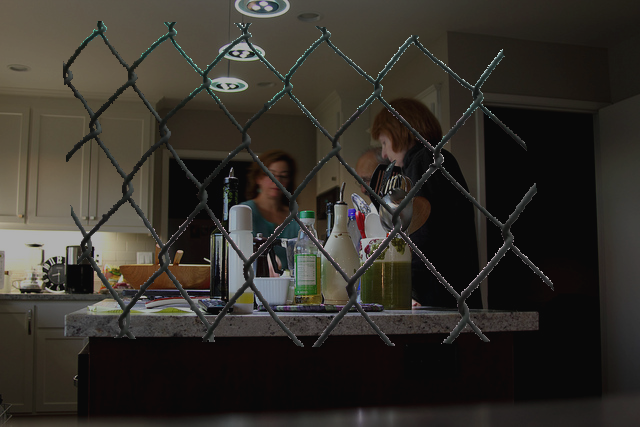

In [8]:
def add_fence(gt_img, fence_list):
                
    fence_sample = random.sample(fence_list,1)


    # Load the fence mask
    fence_img = Image.open(fence_sample[0][0])
    fence_mask = Image.open(fence_sample[0][1])


    # resize it
    fence_img = fence_img.resize(gt_img.size)
    fence_mask = fence_mask.resize(gt_img.size)

    #apply transformations on the fence
    transforms = T.RandomApply(torch.nn.ModuleList([
        T.ColorJitter(hue=(-0.4,0.4)),

        T.RandomRotation((0,10)),
        T.RandomPerspective(),
#         T.RandomAffine(degrees=(0, 20), translate=(0.1, 0.3), scale=(0.8, 0.9)),
        #T.ToTensor(),
        #T.RandomAdjustSharpness(sharpness_factor=2),
        #T.RandomEqualize(),
        #T.RandomAutocontrast(),
        #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]), p=1)

    state = torch.get_rng_state()
    fence_img = transforms(fence_img)
    torch.set_rng_state(state)
    fence_mask = transforms(fence_mask)



    generated_image = gt_img.copy()
    generated_image.paste(fence_img,(0,0),mask=fence_mask)


    return generated_image
    
    
gt_img = Image.open(coco_root + coco_image_folder + "/000000337264.jpg")

gt_img = T.ColorJitter(hue=(-0.05,0.05))(gt_img)
gt_img = T.ColorJitter(brightness=(.8,1))(gt_img)
gt_img = T.ColorJitter(contrast=(0.8,1))(gt_img)


gen_img = add_fence(gt_img,fence_file_list)

gen_img

In [412]:
## CUSTOM DATASET TO GET GROUNF TRUTH AND AUGMENTED IMAGES
class NewFenceDataset(Dataset):
    """Train Fence dataset."""

    def __init__(self, coco_img_root, coco_meta_data, fence_list, img_size = (256,256), num_samples=10000, transform=None):
        """
        Args:
            coco_img_root (string): Directory with all the images.
            coco_meta_data (dictionary): coco JSON annotation
            fence_list (list): list of fence names
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.coco_img_root = coco_img_root 
        self.coco_meta_data = coco_meta_data
        self.fence_list = fence_list
        
        self.num_samples = num_samples
        
        self.img_size = img_size

        self.transform = T.Compose([
                                    T.ToTensor(),
#                                     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ])
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            img_name = self.coco_img_root + '/' +random.sample(self.coco_meta_data['images'],1)[0]["file_name"]

            gt_image = Image.open(img_name)

            if gt_image.mode == "RGB":
                break
        
        #resize to 256x256     
        if (gt_image.size[0] < self.img_size[0]) or (gt_image.size[1] < self.img_size[1]):
            gt_image = gt_image.resize(self.img_size)
        else:
            gt_image = T.RandomCrop(self.img_size)(gt_image)
        
        # augment the gt image
        gt_image = T.ColorJitter(hue=(-0.05,0.05),
                                contrast=0.2, 
                                saturation=0.2, 
                                brightness=0.3)(gt_image)
        # gt_image = T.ColorJitter(brightness=(.8,1))(gt_image)
        # gt_image = T.ColorJitter(contrast=(0.7,1))(gt_image)
        
        # Add the fence to the image
        fenced_image = self.add_fence(gt_image, self.fence_list)
        
        # Transpose
        gt_image = np.asarray(gt_image) #np.transpose(np.asarray(gt_image),(2,0,1))
        fenced_image = np.asarray(fenced_image) #np.transpose(np.asarray(fenced_image),(2,0,1))
        
        # Convert to Tensors
        gt_image = self.transform(gt_image)
        fenced_image = self.transform(fenced_image)
        
        sample = {'gt_image': gt_image, 
                  'fenced_image': fenced_image}
        
#         transform = torch.nn.ModuleList([
#             T.RandomAdjustSharpness(sharpness_factor=2),
#             T.RandomEqualize(),
#             T.RandomAutocontrast(),
#             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         ])

#         sample = transform(sample)

        return sample
    
    
    def add_fence(self, gt_img, fence_list):
                
        fence_sample = random.sample(fence_list,1)
        

        # Load the fence mask
        fence_img = Image.open(fence_sample[0][0])
        fence_mask = Image.open(fence_sample[0][1])


        # resize it
        fence_img = fence_img.resize(gt_img.size)
        fence_mask = fence_mask.resize(gt_img.size)

        #apply transformations on the fence
        transforms = T.RandomApply(torch.nn.ModuleList([
                    T.RandomRotation((0,10)),
                    T.RandomAffine(scale=(0.8,1.4),degrees=0),
                    T.RandomAffine(translate=(0, 0.2),degrees=0),
                    T.RandomHorizontalFlip(p=0.5),
                    T.RandomVerticalFlip(p=0.5),
                    T.RandomPerspective(p=0.2)
        ]), p=0.7)

        
        # Fence transformations
        state = torch.get_rng_state()
        fence_img = transforms(fence_img)
        fence_img = T.GaussianBlur(7)(fence_img)
        fence_img = T.ColorJitter(hue=(-0.5,0.5),contrast=0.4, saturation=0.5)(fence_img)
        # Mask transformations
        torch.set_rng_state(state)
        fence_mask = transforms(fence_mask)
        fence_mask = T.GaussianBlur(3)(fence_mask)

        


        state = torch.get_rng_state()
        generated_image = gt_img.copy()
        torch.set_rng_state(state)
        generated_image.paste(fence_img,(0,0),mask=fence_mask)
        
        
        return generated_image

    
class TestFenceDataset(Dataset):
    """Test Fence dataset."""

    def __init__(self, test_fence_list, img_size = (256,256), transform=None):
        """
        Args:
            fence_list (list): list of fence names
        """

        self.fence_list = test_fence_list
        
        self.img_size = img_size

        self.transform = T.Compose([
                                    T.ToTensor(),
#                                     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ])
        
    def __len__(self):
        return len(self.fence_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.fence_list[idx]

        gt_image = Image.open(img_name)
                
        gt_image = gt_image.resize((256,256))
        
        
        gt_image = np.asarray(gt_image) #np.transpose(np.asarray(gt_image),(2,0,1))
        
        # Convert to Tensors
        gt_image = self.transform(gt_image)
        
#         sample = {'gt_image': gt_image, 
#                   'fenced_image': gt_image}


        return gt_image

In [413]:
len(NewFenceDataset(coco_image_folder, coco_data, fence_file_list))

10000

In [475]:

# from utils.networks import *
# from utils.DataLoaders import *

batch_size = 32
workers = 5
ngpu = 1

image_size = (256,256)
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(NewFenceDataset(coco_root + coco_image_folder, 
                                                               coco_data, 
                                                               fence_file_list,
                                                              img_size = image_size),
                                         batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(TestFenceDataset(test_list,
                                                              img_size = image_size),
                                         batch_size=100,
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [438]:
# Plot some training images
real_batch = next(iter(train_dataloader))

/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converti

/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converti

73


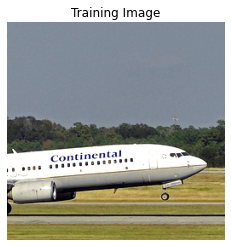

In [461]:
idx=random.randint(0,batch_size-1)
print(idx)
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Image")
plt.imshow(real_batch["gt_image"][idx].cpu().numpy().transpose((1,2,0)))

In [462]:
real_batch["gt_image"].shape

torch.Size([100, 3, 256, 256])

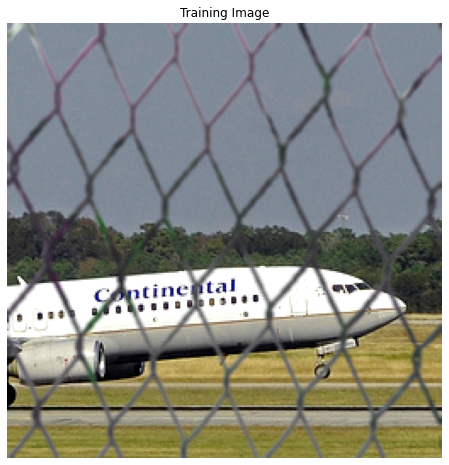

In [463]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Image")
plt.imshow(real_batch["fenced_image"][idx].cpu().numpy().transpose((1,2,0)))

In [464]:
np.save("/ocean/projects/iri180005p/bvw546/FENCE_TRAINING_EXAMPLES", real_batch["fenced_image"].cpu().numpy())

# Encoder Decoder With Attention Architecture

In [186]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [187]:
# ndf = 256
    
# class Defencer(nn.Module):
#     def __init__(self):
#         super(Defencer, self).__init__()
#         # Initialize the resnet encoder
#         self.resnet_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        
#         # Initialize the attention layer
#         #self.attention = nn.Transformer()
        
#         # Initialize the decoder architecture
#         self.decoder = torch.nn.Sequential(
#             nn.ConvTranspose2d(1000,ndf*8,4,1,0),
#             nn.BatchNorm2d(ndf*8),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf*8,ndf*4,4,2,1),
#             nn.BatchNorm2d(ndf*4),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf*4,ndf*2,4,2,1),
#             nn.BatchNorm2d(ndf*2),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf*2,ndf,4,2,1),
#             nn.BatchNorm2d(ndf),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf,ndf,4,2,1, bias=False),
#             nn.BatchNorm2d(ndf),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf,ndf,4,2,1, bias=False),
#             nn.BatchNorm2d(ndf),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ndf,3,4,2,1, bias=False),
#             nn.Tanh()
#         )


#     def forward(self, x):
        
#         x = x.float()
        
#         x = self.resnet_encoder(x)    
        
#         x = x.reshape((32,1000,1,1))
#         #x = self.attention(x)  
#         out = self.decoder(x)
        
        
        
#         return out

In [188]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# REDNET

In [465]:
import math
from torch import nn


class REDNet10(nn.Module):
    def __init__(self, num_layers=5, num_features=64):
        super(REDNet10, self).__init__()
        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv_layers(x)
        out = self.deconv_layers(out)
        out += residual
        out = self.relu(out)
        return out


class REDNet20(nn.Module):
    def __init__(self, num_layers=10, num_features=64):
        super(REDNet20, self).__init__()
        self.num_layers = num_layers

        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        conv_feats = []
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if (i + 1) % 2 == 0 and len(conv_feats) < math.ceil(self.num_layers / 2) - 1:
                conv_feats.append(x)

        conv_feats_idx = 0
        for i in range(self.num_layers):
            x = self.deconv_layers[i](x)
            if (i + 1 + self.num_layers) % 2 == 0 and conv_feats_idx < len(conv_feats):
                conv_feat = conv_feats[-(conv_feats_idx + 1)]
                conv_feats_idx += 1
                x = x + conv_feat
                x = self.relu(x)

        x += residual
        x = self.relu(x)

        return x


class REDNet30(nn.Module):
    def __init__(self, num_layers=15, num_features=64):
        super(REDNet30, self).__init__()
        self.num_layers = num_layers

        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        conv_feats = []
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if (i + 1) % 2 == 0 and len(conv_feats) < math.ceil(self.num_layers / 2) - 1:
                conv_feats.append(x)

        conv_feats_idx = 0
        for i in range(self.num_layers):
            x = self.deconv_layers[i](x)
            if (i + 1 + self.num_layers) % 2 == 0 and conv_feats_idx < len(conv_feats):
                conv_feat = conv_feats[-(conv_feats_idx + 1)]
                conv_feats_idx += 1
                x = x + conv_feat
                x = self.relu(x)

        x += residual
        x = self.relu(x)

        return x

# TRAINING

In [466]:
# !pip freeze > requirements.txt

In [476]:
num_epochs = 5
learning_rate = 1e-3
load = False
last_epoch=22

model_dir = "/ocean/projects/iri180005p/bvw546/tmp/fence_models/TEST"
log_dir = "/ocean/projects/iri180005p/bvw546/tmp/log/TEST"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

model = REDNet10(num_features=32)
model= nn.DataParallel(model)

if load:
    checkpoint = torch.load(os.path.join(model_dir, 'epoch-{0:0>3}.pth'.format(last_epoch)))
    model.load_state_dict(checkpoint)
#     intermediate_test_images = list(np.load(log_dir + '/intermediate_imgs.npy'))
else:
    last_epoch=0
    
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [484]:
writer = SummaryWriter()

# Load in the test data for examples
test_dataset = test_dataloader

if not load:
    for i, data in enumerate(test_dataset):
        np.save(log_dir + '/intermediate_imgs_START', data.detach().cpu().numpy())

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    loop = tqdm(train_dataloader)
    for i, data in enumerate(loop):
        
        # Send the images to the device
        fenced_img = data['fenced_image'].to(device)
        gt_img = data['gt_image'].to(device)

        output = model(fenced_img)
        
        #calculate the loss
        loss = ssim_loss(gt_img,output,3) + nn.MSELoss()(gt_img,output) #nn.L1Loss(gt_img,output)) ## SSIM and L1 for regularization

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        # Update the progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
        
    torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{0:0>3}.pth'.format(last_epoch+epoch)))
    

    with torch.no_grad():
        for i, data in enumerate(test_dataset):
            output = model(data.to(device))
            #intermediate_test_images.append(output.cpu().numpy())
            #save the individual epoch results
            #np.save(log_dir + '/intermediate_imgs', np.array(intermediate_test_images))
            np.save(log_dir + '/intermediate_imgs_{0:0>3}'.format(last_epoch+epoch), output.cpu().numpy())
            print('saved!')
            
              
    # Update the Callbacks
    writer.add_scalar('Loss/train', loss.item(), last_epoch+epoch)
#         writer.add_scalar('Loss/test', np.random.random(), n_iter)
        

/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


In [177]:
# %%bash
# pip install tensorboard
# tensorboard --logdir=runs

Process is terminated.


In [113]:
nn.MSELoss()(gt_img,output) + (ssim_loss(gt_img,output,3))

tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)

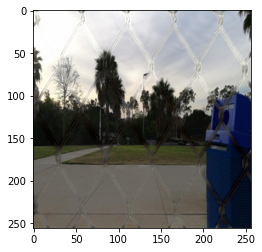

In [483]:
desired_epoch = 1
intermediate_test_images = np.load(log_dir + '/intermediate_imgs_{0:0>3}.npy'.format(desired_epoch))
idx = 13
plt.imshow(intermediate_test_images[idx,:,:,:].transpose(1,2,0))

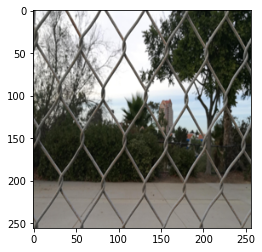

In [479]:
intermediate_test_images = np.load(log_dir + '/intermediate_imgs_START.npy'.format(desired_epoch))
plt.imshow(intermediate_test_images[idx,:,:,:].transpose(1,2,0))

# ADVERSARIAL

In [556]:
parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size',
#                     default=32,
#                     dest='batch_size',
#                     help='Batch size for training',
#                     type=int
#                     )
# parser.add_argument('--n_workers',
#                     default=32,
#                     dest='n_workers',
#                     help='Number of workers for data loading for training',
#                     type=int
#                     )
# parser.add_argument('--load',
#                     action='store_true',
#                     dest='load',
#                     help='Load a previous save'
#                     )
# parser.add_argument('-lr',
#                     default=1e-3,
#                     dest='learning_rate',
#                     help='Learning Rate',
#                     type=float
#                     )
# parser.add_argument('--start_epoch',
#                     default=1,
#                     dest='start_epoch',
#                     help='Epoch to resume training from if load is true',
#                     type=int
#                     )
# parser.add_argument('--test_name',
#                     default="TEST_ADV",
#                     dest='test_name',
#                     help='Save name for the test',
#                     type=str
#                     )
# parser.add_argument('--features',
#                     default=128,
#                     dest='features',
#                     help='Number of features for the autoencoders',
#                     type=int
#                     )
# parser.add_argument('--num_samples',
#                     default=10000,
#                     dest='num_samples',
#                     help='Number of samples the data loader will load',
#                     type=int
#                     )

# args = parser.parse_args()


batch_size = 32
workers = 5

model_name =  "TEST_ADV"

num_epochs = 500
learning_rate = 1e-3
load = False
last_epoch=0
model_dir = "/ocean/projects/iri180005p/bvw546/tmp/fence_models" + "/" + model_name
log_dir = "/ocean/projects/iri180005p/bvw546/tmp/log" + "/" + model_name


os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)


coco_root = "/ocean/datasets/community/COCO"

coco_annotations = "/Dataset_2017/annotations/instances_train2017.json"
coco_image_folder = "/Dataset_2017/train2017"

fence_path = "/ocean/projects/iri180005p/bvw546/data/De-fencing-master/dataset"
fence_testing = "/Test Set/Test_Images"
fence_training = "/Training Set"


#######################################################################
# # # # # # # # # # # # # # Load the Data # # # # # # # # # # # # # # # 
#######################################################################

# TRAINING LIST
fence_file_list = []
for file in glob.glob(fence_path + fence_training + '/Training_Images/*'):
    fence_file_list.append((file, file.replace("Training_Images","Training_Labels").replace("jpg","png")))
fence_file_list[:1]

# TEST LIST
test_list = []
for file in glob.glob(fence_path + fence_testing + '/*'):
    test_list.append(file)
test_list[:1]

# load in the json data
with open(coco_root + coco_annotations) as f:
  coco_data = json.load(f)

image_size = (128,128)
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(NewFenceDataset(coco_root + coco_image_folder, 
                                                               coco_data, 
                                                               fence_file_list,
                                                              img_size = image_size, 
                                                              num_samples=10000),
                                         batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(TestFenceDataset(test_list,
                                                              img_size = image_size),
                                         batch_size=100,
                                         shuffle=False, num_workers=workers)


########################################################################
# # # # # # # # # # # # # # Create the Model # # # # # # # # # # # # # #
########################################################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = REDNet10(num_features=32)
generator = nn.DataParallel(generator)

discriminator = Discriminator()
discriminator = nn.DataParallel(discriminator)

if load:
    checkpoint = torch.load(os.path.join(model_dir, model_name + '_epoch-{0:0>3}.pth'.format(last_epoch)))
    generator.load_state_dict(checkpoint)
    gen_loss_list = list(np.load(log_dir + '/' + model_name + 'GENERATOR_LossList.npy'))
    disc_loss_list = list(np.load(log_dir + '/' + model_name + 'DISCRIMINATOR_LossList.npy'))
#     intermediate_test_images = list(np.load(log_dir + '/intermediate_imgs.npy'))
else:
    last_epoch=0
    gen_loss_list = []
    disc_loss_list = []

generator.to(device)
discriminator.to(device)

optimizerG = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=learning_rate/10)

real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()

#######################################################################
# # # # # # # # # # # # # # Train the Model # # # # # # # # # # # # # #
#######################################################################

writer = SummaryWriter()

# Load in the test data for examples
test_dataset = test_dataloader

if not load:
    for i, data in enumerate(test_dataset):
        np.save(log_dir + '/intermediate_imgs_START', data.detach().cpu().numpy())


/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    loop = tqdm(train_dataloader)
    for i, data in enumerate(loop):
        # Send the images to the device
        fenced_img = data['fenced_image'].to(device)
        gt_img = data['gt_image'].to(device)
        ############################################
        ### TRAIN THE DESCRIMINATOR ###
        ############################################
        ## Train with the all real batch 
        discriminator.zero_grad()
        # Get the array of true labels
        label = torch.full((gt_img.shape[0],), real_label, dtype=torch.float, device=device)
        # Get the output for the true images
        output = discriminator(gt_img).view(-1)
        # Calculate the loss and get the gradients
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        ## Train with the fake batch 
        fake = generator(fenced_img)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()



        ############################################
        ### TRAIN THE Generator ###
        ############################################
        optimizerG.zero_grad()
        # SKIP output = generator(fenced_img)

        # Calculate the adverasarial loss
        label.fill_(real_label)
        D_prediction = discriminator(fake).view(-1)
        
        #calculate the loss
        adv_loss = criterion(D_prediction, label)
        sim_loss = 0.4 * ssim_loss(gt_img,fake,3) + 0.3 * nn.MSELoss()(gt_img,fake) 

        loss = 0.5 * sim_loss + 0.5 * adv_loss
                            #nn.L1Loss(gt_img,output)) ## SSIM and L1 for regularization


        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizerG.step()
        
        # Update the progress bar
        loop.set_description(f"Epoch [{last_epoch+epoch}/{last_epoch+num_epochs}]")
        loop.set_postfix(loss=loss.item())
        
    torch.save(generator.state_dict(), os.path.join(model_dir, model_name + 'GENERATOR_epoch-{0:0>3}.pth'.format(last_epoch+epoch)))
    torch.save(discriminator.state_dict(), os.path.join(model_dir, model_name + 'DISCRIMINATOR_epoch-{0:0>3}.pth'.format(last_epoch+epoch)))

    # Save the loss
    gen_loss_list.append((last_epoch+epoch,(sim_loss.item(),adv_loss.item())))
    disc_loss_list.append((last_epoch+epoch,errD.item()))

    np.save(log_dir + '/' + model_name + 'GENERATOR_LossList.npy', np.array(gen_loss_list))
    np.save(log_dir + '/' + model_name + 'DISCRIMINATOR_LossList.npy', np.array(disc_loss_list))

    with torch.no_grad():
        for i, data in enumerate(test_dataset):
            output = generator(data.to(device))
            #intermediate_test_images.append(output.cpu().numpy())
            #save the individual epoch results
            #np.save(log_dir + '/intermediate_imgs', np.array(intermediate_test_images))
            np.save(log_dir + '/' + model_name + '_intermediate_imgs_{0:0>3}'.format(last_epoch+epoch), output.cpu().numpy())
            print('saved!')
            
              
    # Update the Callbacks
    writer.add_scalar('Loss/train', loss.item(), last_epoch+epoch)
#         writer.add_scalar('Loss/test', np.random.random(), n_iter)

  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

saved!


  0%|          | 0/313 [00:00<?, ?it/s]/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/jet/home/bvw546/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its da

In [583]:
class Discriminator(nn.Module):
    def __init__(self,num_features=32): # ngpu, 
        super(Discriminator, self).__init__()
        # self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x num_features x num_features
            nn.Conv2d(3, num_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_features) x 32 x 32
            nn.Conv2d(num_features, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_features*2) x 16 x 16
            nn.Conv2d(num_features * 2, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_features*4) x 8 x 8
            nn.Conv2d(num_features * 4, num_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_features*8) x 4 x 4
            nn.Conv2d(num_features * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input) 

In [584]:
discriminator = Discriminator()
discriminator = nn.DataParallel(discriminator)
discriminator.to(device)
discriminator(gt_img).shape

torch.Size([32, 1])

In [592]:
output.shape

torch.Size([16])

In [596]:
gt_img.shape

torch.Size([16, 3, 128, 128])